# Here we try to get the taxonomic IDs from the Blast tabs

In [1]:
import pandas as pd

In [2]:
unique_sequences = pd.read_csv("unique_sequences.csv")

In [3]:
unique_sequences.head()

,Accession,Sequence,Gene names,Organism,Organism ID,Protein names,Taxonomic lineage IDs,unique_id
0,P0CAB3,MEEVITIAQIVHRGTDILSLNNEEIEALVDEIYSTLKGSNDIKNIR...,Ken-072,African swine fever virus (isolate Pig/Kenya/K...,561445,Uncharacterized protein M1249L (pM1249L),561445,African_swine_fever_virus_(isolate_Pig/Kenya/K...
1,A0A0C5AWP7,MEEVITIAQIVHRGTDILSLNNEEIEALVDEIYSTLKGSNDIKNIR...,BA71V-M1249L,African swine fever virus (ASFV),10497,BA71V-M1249L,10497,African_swine_fever_virus_(ASFV)|BA71V-M1249L|...
2,A0A2Z5DFV5,MEEVITIAQIVHRGTDILSLNNEEIEALVDEIYSTLKGSNDIKNIR...,M1249L,African swine fever virus (ASFV),10497,PM1249L,10497,African_swine_fever_virus_(ASFV)|M1249L|A0A2Z5...
3,A0A2Z5DGI2,MEEVITIAQIVHRGTDILSLNNEEIEALVDEIYSTLKGSNDIKNIR...,M1249L,African swine fever virus (ASFV),10497,PM1249L,10497,African_swine_fever_virus_(ASFV)|M1249L|A0A2Z5...
4,A0A0C5AWA9,MEEVITIAQIVHRGTDILSLNNEEIEALVDEIYSTLKGSNDIKNIR...,BA71V-M1249L,African swine fever virus (ASFV),10497,BA71V-M1249L,10497,African_swine_fever_virus_(ASFV)|BA71V-M1249L|...


In [4]:
unique_sequences["Taxonomic lineage IDs"].to_csv("taxids.list", sep="\t", index=False, header=False)

In [5]:
tax_ids = unique_sequences["Taxonomic lineage IDs"]

In [6]:
columns = ["qname", "sname", "identity", "length", "mismatch",
           "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore", "coverage"]
reverse_blast = pd.read_csv("all_five_eval_10.blast", sep="\t", header=None, names=columns)

In [7]:
reverse_blast.head()

,qname,sname,identity,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,coverage
0,AFSV,P0CAB3,100.000,1250,0,0,1,1250,1,1250,0.0,2593.0,100
1,AFSV,A0A0C5AWP7,98.960,1250,13,0,1,1250,1,1250,0.0,2575.0,100
2,AFSV,A0A2Z5DFV5,98.880,1250,14,0,1,1250,1,1250,0.0,2572.0,100
3,AFSV,A0A2Z5DGI2,98.880,1250,14,0,1,1250,1,1250,0.0,2571.0,100
4,AFSV,A0A0C5AWA9,98.881,1251,12,2,1,1250,1,1250,0.0,2558.0,100


In [8]:
qnames = reverse_blast.qname.unique()
queries = {}
for q in qnames:
    queries[q] = reverse_blast[reverse_blast.qname == q]

In [9]:
def get_top_evalue(df):
    out_df = pd.DataFrame()
    unique_genes = df.sname.unique()
    for gene in unique_genes:
        rows = df[df.sname == gene]
        top_evalue = min(rows.evalue)
        top_row = rows[rows.evalue == top_evalue]
        if len(top_row) > 1:
            top_score = max(top_row.bitscore)
            top_row = top_row[top_row.bitscore == top_score]
        out_df = out_df.append(top_row)
    return out_df

In [10]:
qnames

array(['AFSV', 'CroV', 'Faustovirus', 'Mimivirus', 'PBCV-1'], dtype=object)

In [11]:
CroV_unique = get_top_evalue(queries["CroV"])
ASFV_unique = get_top_evalue(queries["AFSV"])
Faustovirus_unique = get_top_evalue(queries["Faustovirus"])
PBCV_1_unique = get_top_evalue(queries["PBCV-1"])
Mimivirus_unique = get_top_evalue(queries["Mimivirus"])

In [12]:
CroV_unique.head()

,qname,sname,identity,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,coverage
30,CroV,E3T4V5,100.000,869,0,0,1,869,1,869,0.000000e+00,1785.0,100
31,CroV,H2EAZ0,30.183,709,388,33,93,741,87,748,8.660000e-47,173.0,77
36,CroV,A0A3S5HLA8,29.504,705,398,33,93,741,82,743,3.250000e-44,167.0,75
39,CroV,A0A2P1ELM1,27.298,729,417,26,93,742,79,773,1.980000e-41,158.0,77
43,CroV,A0A167RD30,29.130,690,388,28,93,741,83,712,2.660000e-41,156.0,75


In [13]:
def match_gene_to_identity(accession_df, blast_df):
    identities = []
    for acc in accession_df.Accession:
        if acc in list(blast_df.sname):
            try:
                identities.append(round(float(blast_df[blast_df.sname == acc].identity), 2))
            except:
                print(blast_df[blast_df.sname == acc].identity)
        else:
            identities.append(0)
    return identities

In [16]:
unique_sequences["CroV_ident"] = match_gene_to_identity(unique_sequences, CroV_unique)
unique_sequences["ASFV_ident"] = match_gene_to_identity(unique_sequences, ASFV_unique)
unique_sequences["Mimivirus_ident"] = match_gene_to_identity(unique_sequences, Mimivirus_unique)
unique_sequences["Faustovirus_ident"] = match_gene_to_identity(unique_sequences, Faustovirus_unique)
unique_sequences["PBCV_1_ident"] = match_gene_to_identity(unique_sequences, PBCV_1_unique)

In [19]:
blast_identity_table= unique_sequences[["Accession", "CroV_ident", "ASFV_ident",
                                        "Mimivirus_ident", "Faustovirus_ident", "PBCV_1_ident"]]

In [22]:
blast_identity_table

,Accession,CroV_ident,ASFV_ident,Mimivirus_ident,Faustovirus_ident,PBCV_1_ident
0,P0CAB3,0.00,100.00,0.00,22.26,0.00
1,A0A0C5AWP7,0.00,98.96,0.00,22.57,0.00
2,A0A2Z5DFV5,0.00,98.88,0.00,22.26,0.00
3,A0A2Z5DGI2,0.00,98.88,0.00,22.36,0.00
4,A0A0C5AWA9,0.00,98.88,0.00,22.21,0.00
5,P0CAB4,0.00,97.36,0.00,22.00,0.00
6,A0A0A1DYC7,0.00,96.72,0.00,22.22,0.00
7,A9JLS9,0.00,96.72,0.00,22.22,0.00
8,A0A1C6ZXW2,0.00,96.64,0.00,22.12,0.00
9,A9JL09,0.00,96.64,0.00,22.12,0.00


In [27]:
import matplotlib.pyplot as plt

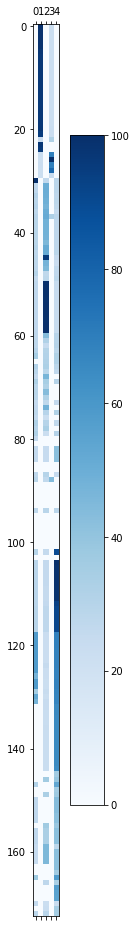

In [52]:
plt.matshow(blast_identity_table.iloc[:, 1:], cmap="Blues")
plt.colorbar()